# Mackey-Glass Time Series Prediction Using Look Up Table

## Introduction

The purpose of this work is to create a fuzzy system for time series prediction of Mackey-Glass equation, which is delay differential equation:
\begin{equation}
    \frac{dx(t)}{dt} = \beta \frac{x(t-\tau)}{1+x^{n}(t-\tau)}-\gamma x(t)  
\end{equation}
The goal is in time $t_1$ to predict $x(t_1+k)$, we choose\footnote{$\tau$ should be more than 17.} $\tau = 30$. We need to set $n \approx 10$, because that is the value where chaos appears. The remaining two parameters are set as follows: $\beta = 0.2$ and $\gamma = 0.1$.

In [2]:
# imports
from math import pow
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Mackey-Glass differential eq. parameters
Beta = 0.2
Gamma = 0.1
Tau = 30
n = 10
# initializing an array of random values for numerical simulation
y = np.random.rand(Tau+1)
# lenght of our simulation
samples = 600

## Implementation of Mackey-Glass

We can approximate function (1) like this:
\begin{equation}
    x(t+k)\approx x(t)+k\frac{dx(t)}{dt}
\end{equation}
We put equations (1) and (2) together and $k=1$, since we go step by step by samples, hence the following equation is our approximation:
\begin{equation}
    x(t+1)= x(t)+\beta \frac{x(t-\tau)}{1+x^{n}(t-\tau)}-\gamma x(t)  
\end{equation}
Put our constants in equation (3):
\begin{equation}
    x(t+1)=x(t)+ \frac{0.2x(t-30)}{1+x^{10}(t-30)}-0.1 x(t)  
\end{equation}
Which is the final form of our equation.

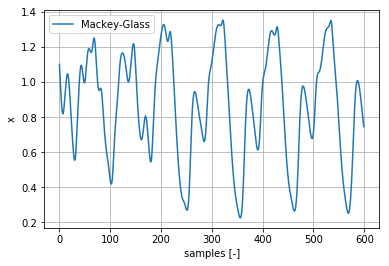

In [14]:
# calculating Mackey-Glass eq. for samples
for _ in range(samples):
    value=y[-1]+Beta*y[-1-Tau]/(1+pow(y[-1-Tau],n))-Gamma*y[-1]
    y = np.r_[y,value]

# we dont need those first random values  
y=y[-samples:]

# lets plot it
plt.figure()
plt.plot(y,label='Mackey-Glass')
plt.legend()
plt.xlabel('samples [-]')
plt.ylabel('x')
plt.grid(True)
plt.show()

## Design of a fuzzy system

The goal is to create a fuzzy system only from input-output data. We use only the first 300 values of x. The n represents number of statements in fuzzy IF-THEN rule. Thus we make a input-output pairs for creating fuzzy rules for look up table system only from input set.
\begin{align*}
    [x(0),x(1),...,x(n-1);x(n)] \\
    [x(1),x(2),...,x(n);x(n+1)] \\
            . \\
            . \\
            . \\
    [x(299-n),x(299-n+1),...,x(298);x(299)] \\
\end{align*}

We choose that our system is Look up table with product inference engine, triangular fuzzyfier and center average defuzzyfier:
\begin{equation}
    f(x)=\frac{\sum_{l=1}^M \overline{y}^l(\prod_{i=1}^n \mu_{A_i^l}(x))}{\sum_{l=1}^M (\prod_{i=1}^n \mu_{A_i^l}(x))} 
\end{equation}

Where M is number of Fuzzy IF-THEN rules and n is number of fuzzy statements in one rule.
With fuzzy IF-THEN rules looking like this:
\begin{equation}
    IF \bigwedge_{i=0}^{n-1} ( x(k-n) \ is \ A_i^l )\ THEN \ x(k+1) \ is \ B^l
\end{equation}

And we use triangular membership function:
\begin{equation}
    \mu_{A_i^l}(x) = \left\{ \begin{array}{r@{\quad}c}
    1-\frac{|x-c_{A_i^l}|}{D}, & x \in (c_{A_i^l}-D,c_{A_i^l}+D) \\
    0, & else \\ \end{array} \right.
\end{equation}

In [15]:
# Look Up Table parameters
TrainingData = y[0:300]    #Training data for fuzzy system, we use only first 300 samples
TestingData = y            #We useall of our data for testing
NumStatements = 5          #Number of fuzzy-statements in fuzzy IF-THEN rule
NumFuzzySets = 7           #Number of Fuzzy Sets in input and output area

# definine our membership function
def triangle(x,center,D):
    if x<=(center-D):
        return 0
    if x>=(center+D):
        return 0
    else:
        return -(1/D)*abs(x-center)+1 

In [16]:
#Creating an array of fuzzy-sets centers
Minimum = min(TrainingData)
Maximum = max(TrainingData)
D = (Maximum-Minimum)/(NumFuzzySets-1)
FuzzySetsCenters=[]
for i in range(NumFuzzySets-1):
    FuzzySetsCenters.append(Minimum+i*D)
FuzzySetsCenters.append(Maximum)

In [17]:
# creating INPUT-OUTPUT pairs
RulesData = []
for i in range(len(TrainingData)-NumStatements):
    rule = []
    for j in range(NumStatements):
        rule.append(TrainingData[i+j])
    RulesData.append(rule)

# fuzzy IF-THEN rules
FuzzyRules = []
for i in range(len(RulesData)):
    rulefp = []
    for j in range(NumStatements):
        fp = []
        for k in range(NumFuzzySets):
            _ = triangle(RulesData[i][j],FuzzySetsCenters[k],D)
            fp.append(_)
        rulefp.append(FuzzySetsCenters[fp.index(max(fp))])
    FuzzyRules.append(rulefp)

Since the number of input-output is usually large, and with each pair generating a single rule, there is high chance, that there are some conflict ones. Which means, there are rules with same IF part but different THEN parts. Therefore, we assign degree of a rule:
\begin{equation}
D(Ru^{(l)})=\mu_{B^{l*}}(y_0^p)\prod_{i=1}^{n}\mu_{A_i^{l*}}(x_{0i}^p)
\end{equation}
Hence we choose non-conflict fuzzy rules, and from conflict rules we choose ones with the highes degree. Chosen Fuzzy Rules are our fuzzy system base.

In [18]:
# function, which assign degree to a fuzzy IF-THEN rule
def DegreeRule(RuleData,FuzzyRule):
    value = 1
    for i in range(len(RuleData)):
        value=value*triangle(RuleData[i],FuzzyRule[i],D)
    return value            

#Assign degrees to fuzzy IF-THEN rules and deleting conflict ones with lower degree
FRules = FuzzyRules.copy() 
for i in range(len(FuzzyRules)):
    for j in range(i,len(FuzzyRules)):
        if FuzzyRules[i][:-1] == FuzzyRules[j][:-1] and not i==j:
            Degree1 = DegreeRule(RulesData[i],FuzzyRules[i])
            Degree2 = DegreeRule(RulesData[j],FuzzyRules[j])
            if Degree1 > Degree2:
                FRules[j] = None
            else:
                FRules[i] = None
        else:
            pass

#New, non-conflict fuzzy IF-THEN rules, our fuzzy system base
FuzzyRules=[]
for i in range(len(FRules)):
    if not FRules[i] == None:
        FuzzyRules.append(FRules[i])

## Look Up Table prediciton results

We have used first 300 samples to create our Look Up Rable, now we use our created system to compute whole interval including our testing data. Once again, here is equation of our fuzzy system:
\begin{equation}
    f(x)=\frac{\sum_{l=1}^M \overline{y}^l(\prod_{i=1}^n \mu_{A_i^l}(x))}{\sum_{l=1}^M (\prod_{i=1}^n \mu_{A_i^l}(x))} 
\end{equation}
Which we will now write as a function in python:

In [19]:
# function of our fuzzy system
def MamdaniValue(X,FuzzyRules,D):
    pom1 = 0
    pom2 = 0
    for FuzzyRule in FuzzyRules:
        pom3 = 1
        for i in range(len(X)):
            pom3 = pom3*triangle(X[i],FuzzyRule[i],D)
        pom1=pom1+FuzzyRule[-1]*pom3
        pom2=pom2+pom3
    try:
        return (pom1/pom2)
    except ZeroDivisionError:
        return 0

In [20]:
# Calculating predicted value, real Mackey-Glass and absolute deviation
TestingInputs = []
for i in range(len(TestingData)-NumStatements):
    vector = []
    for j in range(NumStatements-1):
        vector.append(TestingData[i+j])
    TestingInputs.append(vector)

Predicted=[]
for i in range(NumStatements):
    Predicted.append(TestingData[i]) # Insert values, for same lenght of arrays
for j in range(len(TestingData)-NumStatements):
    Predicted.append(MamdaniValue(TestingData[j:j+NumStatements-1],FuzzyRules,D))
    
Deviation=[]
for i in range(len(TestingData)):
    Deviation.append(abs(TestingData[i]-Predicted[i]))

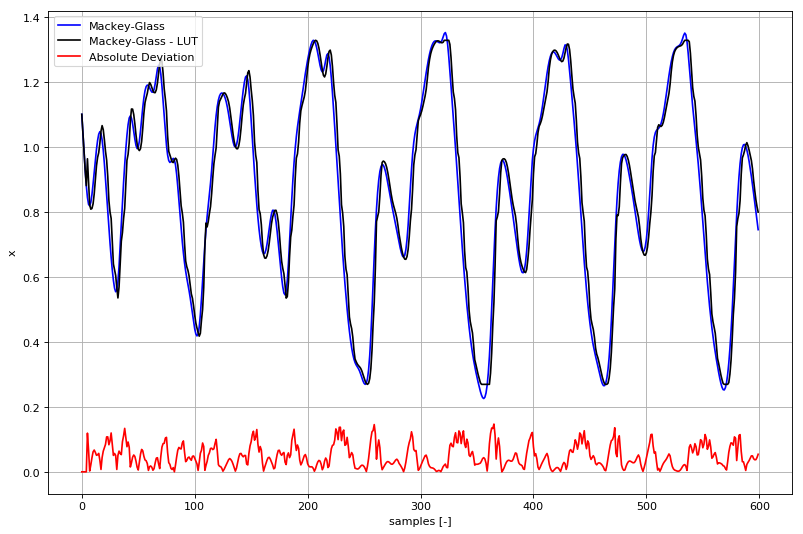

In [21]:
# ploting predicted value, real Mackey-Glass and absolute deviation
plt.figure(dpi=80, figsize=(12,8))
plt.plot(TestingData,'b',label='Mackey-Glass')
plt.plot(Predicted,'k',label='Mackey-Glass - LUT')
plt.plot(Deviation,'r',label='Absolute Deviation')
plt.legend()
plt.xlabel('samples [-]')
plt.ylabel('x')
plt.grid(True)
plt.show()